# Modelagem Preditiva

A Modelagem Preditiva envolve a criação de um modelo estatístico ou de aprendizado de máquina para prever um evento ou resultado futuro. No contexto do desafio de e-commerce com o dataset da Olist, a tarefa é criar um modelo de regressão logística para prever a probabilidade de conversão dos clientes (se um pedido será entregue ou não).

## Instalação de bibliotecas

In [2]:
%pip install pandas matplotlib seaborn scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Preparação dos Dados

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns


# Carregar os datasets
customers = pd.read_csv("olist_customers_dataset.csv")
geolocation = pd.read_csv("olist_geolocation_dataset.csv")
order_items = pd.read_csv("olist_order_items_dataset.csv")
order_payments = pd.read_csv("olist_order_payments_dataset.csv")
order_reviews = pd.read_csv("olist_order_reviews_dataset.csv")
orders = pd.read_csv("olist_orders_dataset.csv")
products = pd.read_csv("olist_products_dataset.csv")
sellers = pd.read_csv("olist_sellers_dataset.csv")
product_category_translation = pd.read_csv("product_category_name_translation.csv")

# Merge para obter payment_value, payment_installments:
orders = pd.merge(orders, order_payments[['order_id', 'payment_value', 'payment_installments']], on='order_id', how='left')

# Merge para obter review_score:
orders = pd.merge(orders, order_reviews[['order_id', 'review_score']], on='order_id', how='left')

# Merge para freight_value (requer dois merges):
# Merge order_items com orders para customer_id:
order_items_merged = pd.merge(order_items, orders[['order_id', 'customer_id']], on='order_id', how='left')

# Calcule o frete médio por pedido
frete_medio = order_items_merged.groupby('order_id')['freight_value'].mean().reset_index()

# Merge com orders
orders = pd.merge(orders, frete_medio, on='order_id', how='left')

# Crie a variável alvo (conversão)
orders['converted'] = orders['order_status'].apply(lambda x: 1 if x == 'delivered' else 0)

# Selecione as features para o modelo.  Exemplos:
features = ['payment_value', 'freight_value', 'payment_installments', 'review_score']
X = orders[features]

# Preencha valores ausentes (se houver) na variável 'review_score'
X['review_score'] = X['review_score'].fillna(X['review_score'].median())  # Ou outra estratégia

y = orders['converted']

C:\Users\salom\AppData\Local\Temp\ipykernel_19300\2122939727.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['review_score'] = X['review_score'].fillna(X['review_score'].median())  # Ou outra estratégia


## Divisão Treino/Teste

In [8]:
print("Valores NaN em X:\n", X.isna().sum())
print("\nValores NaN em y:\n", y.isna().sum())

X.dropna(inplace=True) # Remove linhas com NaN em qualquer coluna de X. ATENÇÃO: certifique-se de que o y seja consistente com X
y = y[X.index] #garante a correspondencia entre as bases

print("Valores NaN em X:\n", X.isna().sum())
print("\nValores NaN em y:\n", y.isna().sum())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y) 

Valores NaN em X:
 payment_value             1
freight_value           833
payment_installments      1
review_score              0
dtype: int64

Valores NaN em y:
 0
Valores NaN em X:
 payment_value           0
freight_value           0
payment_installments    0
review_score            0
dtype: int64

Valores NaN em y:
 0


C:\Users\salom\AppData\Local\Temp\ipykernel_19300\3255796987.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.dropna(inplace=True) # Remove linhas com NaN em qualquer coluna de X. ATENÇÃO: certifique-se de que o y seja consistente com X


## Treinamento do Modelo

In [9]:
model = LogisticRegression(random_state=42)  # Você pode ajustar os hiperparâmetros aqui
model.fit(X_train, y_train)

LogisticRegression(random_state=42)

## Avaliação do Modelo

Acurácia: 0.977616260371776
Precisão: 0.977616260371776
Recall: 1.0
F1-Score: 0.9886814544981462


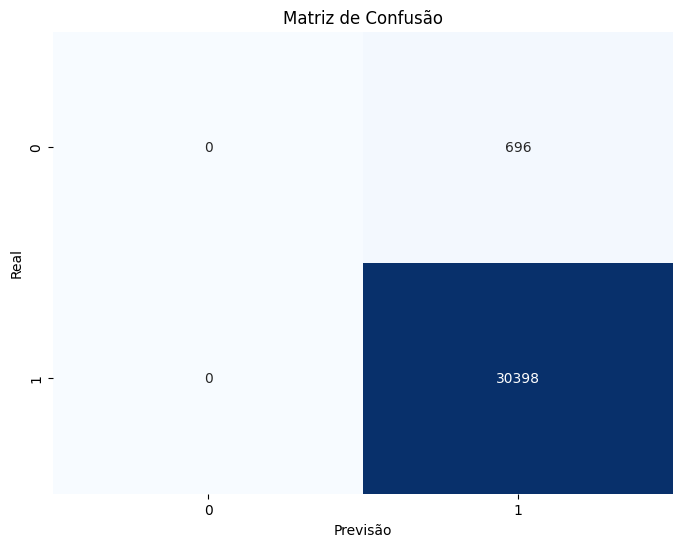

c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Relatório de Classificação (base de teste):
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       696
           1       0.98      1.00      0.99     30398

    accuracy                           0.98     31094
   macro avg       0.49      0.50      0.49     31094
weighted avg       0.96      0.98      0.97     31094

AUC-ROC (base de teste):
 0.8433331877550928


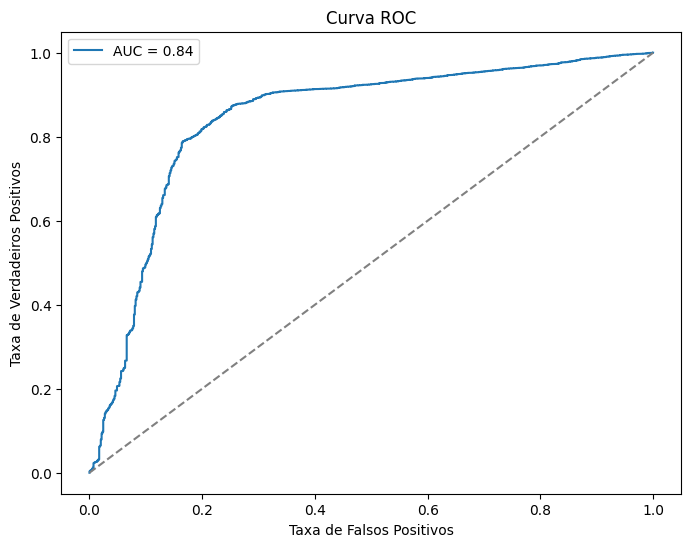

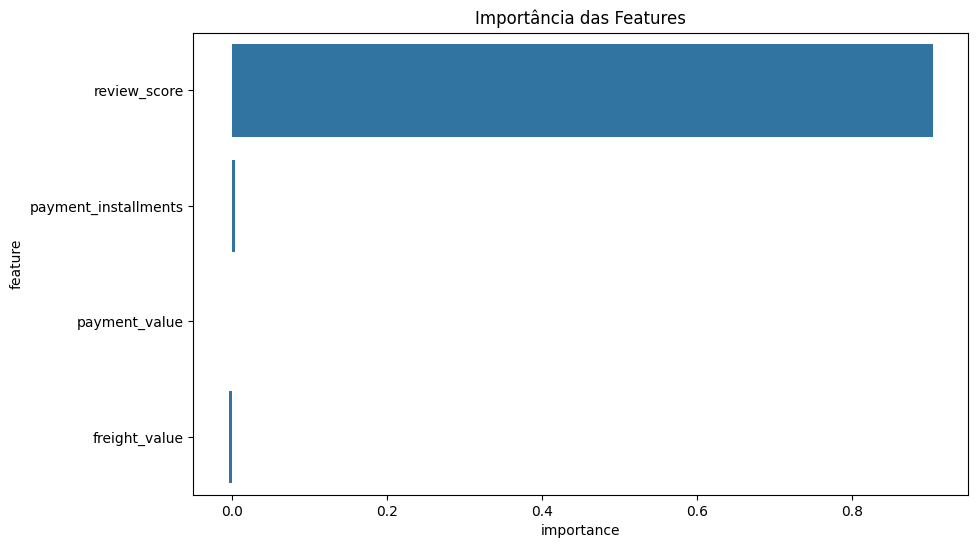

In [10]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

y_pred = model.predict(X_test)

print("Acurácia:", accuracy_score(y_test, y_pred))
print("Precisão:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-Score:", f1_score(y_test, y_pred))

# Matriz de Confusão:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Previsão')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()


# Previsões nas bases de treino e teste:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Probabilidades (para a curva ROC)
y_prob = model.predict_proba(X_test)[:, 1]


# Métricas de Avaliação:
print("Relatório de Classificação (base de teste):\n", classification_report(y_test, y_pred_test))

print("AUC-ROC (base de teste):\n", roc_auc_score(y_test, y_prob))


# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_prob):.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray') # Linha base (classificador aleatório)
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend()
plt.show()


# Importância das Features (coeficientes da regressão logística)
feature_importance = pd.DataFrame({'feature': features, 'importance': model.coef_[0]})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Importância das Features')
plt.show()
